# Análise e Criação de um Sistema de Recomendação de Animes

Este notebook tem como objetivo analisar, compreender e adaptar um dataset de animes para a criação de um sistema de recomendação utilizando Machine Learning.


Analistas: Ariel Angelo Guiliane Mendes de Almeida e João Pedro José Santos da Silva Guedes

## Dataset
O conjunto de dados (dataset) utilizado neste projeto foi retirado do Kaggle e é composto por diversos arquivos, entre eles:

* `anime-dataset-2023.csv`
* `users-details-2023.csv`
* `users-score-2023.csv`

A fonte dos dados utilizados para criar esse dataset foi o MyAnimeList.

**Disponível em:** https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/data

## Links úteis

- Repositório: https://github.com/sudjoao/ml-residencia-ti
- Relatório detalhado do projeto: https://pt.overleaf.com/project/690e1f766b0b72da562e23c3

## Entendimento dos Dados

Nesta etapa será explorado como os dados estão organizados, o significado de cada um deles, entre outros. O objetivo é que no fim dessa seção a compreensão dos dados seja completa.

In [1]:
# Importações e configuração
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gdown
warnings.filterwarnings('ignore')

In [2]:
# Leitura dos arquivos principais do dataset, que foram adicionados ao google drive
file_id_1 = "1BgwAvpzXJp6ZXVZNQsCm5p7aXL0ne9jV"
gdown.download(id=file_id_1, output="anime-dataset-2023.csv", quiet=False)
df1 = pd.read_csv("anime-dataset-2023.csv")

file_id_2 = "1ohF_Cb3PR6QLW0ACYMU-RcmdbLfmQ5jn"
gdown.download(id=file_id_2, output="user-dataset-2023.csv", quiet=False)
df2 = pd.read_csv("user-dataset-2023.csv")

Downloading...
From: https://drive.google.com/uc?id=1BgwAvpzXJp6ZXVZNQsCm5p7aXL0ne9jV
To: /Users/sudjoao/Dev/UFG/3-machine-learning/ml-residencia-ti/anime-dataset-2023.csv
100%|█| 15.9M/15.9M [00:00<00:00, 24.5MB/
Downloading...
From (original): https://drive.google.com/uc?id=1ohF_Cb3PR6QLW0ACYMU-RcmdbLfmQ5jn
From (redirected): https://drive.google.com/uc?id=1ohF_Cb3PR6QLW0ACYMU-RcmdbLfmQ5jn&confirm=t&uuid=13ea2328-af93-4e0b-aa12-ddd95fb9e78d
To: /Users/sudjoao/Dev/UFG/3-machine-learning/ml-residencia-ti/user-dataset-2023.csv
100%|█| 1.16G/1.16G [00:17<00:00, 64.6MB/


In [3]:
print("DataFrame animes:")
display(df1.head())

print("DataFrame usuários:")
display(df2.head())

DataFrame animes:


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


DataFrame usuários:


,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


In [4]:
print("\n--- Informações do DataFrame df1 (animes) ---\n")
df1.info()
print("\n--- Estatísticas Descritivas do DataFrame df1 (animes) ---\n")
display(df1.describe(include='all'))

print("\n--- Informações do DataFrame df2 (usuários) ---\n")
df2.info()
print("\n--- Estatísticas Descritivas do DataFrame df2 (usuários) ---\n")
display(df2.describe(include='all'))


--- Informações do DataFrame df1 (animes) ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
count,24905.000000,24905,24905,24905,24905,24905,24905,24905,24905,24905,...,24905,24905,24905,24905,24905,24905.000000,24905.000000,24905,2.490500e+04,24905
unique,NaN,24901,10134,23796,567,1006,20113,7,252,15213,...,1547,17,331,7,15198,NaN,NaN,8281,NaN,24720
top,NaN,Azur Lane,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,No description available for this anime.,TV,1.0,Not available,...,UNKNOWN,Original,24 min per ep,PG-13 - Teens 13 or older,UNKNOWN,NaN,NaN,UNKNOWN,NaN,https://cdn.myanimelist.net/img/sp/icon/apple-...
freq,NaN,2,14577,128,9213,4929,4535,7597,11532,915,...,10526,9622,1961,8502,4612,NaN,NaN,9213,NaN,186
mean,29776.709014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12265.388356,432.595222,NaN,3.710496e+04,NaN
std,17976.076290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7187.428393,4353.181647,NaN,1.568252e+05,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN
25%,10507.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6040.000000,0.000000,NaN,2.090000e+02,NaN
50%,34628.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12265.000000,1.000000,NaN,1.056000e+03,NaN
75%,45240.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18491.000000,18.000000,NaN,9.326000e+03,NaN



--- Informações do DataFrame df2 (usuários) ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB

--- Estatísticas Descritivas do DataFrame df2 (usuários) ---



,user_id,Username,anime_id,Anime Title,rating
count,2.432519e+07,24324959,2.432519e+07,24325191,2.432519e+07
unique,NaN,270032,NaN,16611,NaN
top,NaN,trafagibr,NaN,Death Note,NaN
freq,NaN,2986,NaN,126492,NaN
mean,4.403843e+05,NaN,9.754686e+03,NaN,7.622930e+00
std,3.669469e+05,NaN,1.206196e+04,NaN,1.661510e+00
min,1.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00
25%,9.718800e+04,NaN,8.730000e+02,NaN,7.000000e+00
50%,3.879780e+05,NaN,4.726000e+03,NaN,8.000000e+00
75%,5.280430e+05,NaN,1.316100e+04,NaN,9.000000e+00


### 📊 Dicionário de Dados: df1 (Animes)

Baseado no `head()`: `anime_id=1, Name='Cowboy Bebop', Score='8.75', Episodes='26.0', ...`

| Coluna | Tipo de Dados | Descrição (Mais Assertiva) |
| :--- | :--- | :--- |
| **anime\_id** | Inteiro (int64) | O ID único do anime (ex: `1`). Chave primária. |
| **Name** | Texto (Object) | O nome principal do anime (ex: `Cowboy Bebop`). |
| **English name** | Texto (Object) | O nome em inglês (ex: `Cowboy Bebop`). |
| **Other name** | Texto (Object) | O nome em outro idioma, comumente o japonês (ex: `カウボーイビバップ`). |
| **Score** | Texto (Object) | A pontuação média. **É um texto (object)**, mas representa um número decimal (ex: `8.75`). Precisa ser convertido para `float` para cálculos. |
| **Genres** | Texto (Object) | Uma **string única com gêneros separados por vírgula** (ex: `Action, Award Winning, Sci-Fi`). |
| **Synopsis** | Texto (Object) | O resumo da história (ex: `Crime is timeless...`). |
| **Type** | Texto (Object) | O formato da mídia (ex: `TV`, `Movie`, `OVA`). |
| **Episodes** | Texto (Object) | O número de episódios. **É um texto (object)**, (ex: `26.0`). Provavelmente para acomodar valores não numéricos (como "Unknown"). Precisa ser convertido para numérico. |
| **Aired** | Texto (Object) | Uma string com o período de exibição (ex: `Apr 3, 1998 to Apr 24, 1999`). |
| **Premiered** | Texto (Object) | A temporada de estreia (ex: "Spring 1998"). |
| **Status** | Texto (Object) | O status de exibição (ex: "Finished Airing"). |
| **Producers** | Texto (Object) | String com os produtores (pode ter mais de um, separados por vírgula). |
| **Licensors** | Texto (Object) | String com as empresas licenciadoras. |
| **Studios** | Texto (Object) | O estúdio de animação principal (ex: `Sunrise`). |
| **Source** | Texto (Object) | O material original (ex: `Original`, `Manga`). |
| **Duration** | Texto (Object) | A duração, geralmente por episódio (ex: `24 min per ep`). |
| **Rating** | Texto (Object) | A classificação indicativa, incluindo descrição (ex: `R - 17+ (violence & profanity)`). |
| **Rank** | Texto (Object) | A posição no ranking. **É um texto (object)** (ex: `41.0`). Precisa ser convertido para numérico. |
| **Popularity** | Inteiro (int64) | O ranking de popularidade (ex: `43`). |
| **Favorites** | Inteiro (int64) | O número de usuários que favoritaram o anime (ex: `78525`). |
| **Scored By** | Texto (Object) | O número de usuários que deram nota. **É um texto (object)** (ex: `914193.0`). Precisa ser convertido para numérico. |
| **Members** | Inteiro (int64) | O número total de membros na comunidade do anime (ex: `1771505`). |
| **Image URL** | Texto (Object) | O link para a imagem de capa (ex: `https://cdn.myanimelist.net/...`). |

---

### 👥 Dicionário de Dados: df2 (Usuários)

Baseado no `head()`: `user_id=1, Username='Xinil', anime_id=21, Anime Title='One Piece', rating=9`

| Coluna | Tipo de Dados | Descrição (Mais Assertiva) |
| :--- | :--- | :--- |
| **user\_id** | Inteiro (int64) | O ID único do usuário (ex: `1`). |
| **Username** | Texto (Object) | O nome de usuário (ex: `Xinil`). |
| **anime\_id** | Inteiro (int64) | O ID do anime avaliado (ex: `21`). Chave estrangeira que liga ao `df1.anime_id`. |
| **Anime Title** | Texto (Object) | O nome do anime avaliado (ex: `One Piece`). (Obs: parece redundante, já que temos o `anime_id`). |
| **rating** | Inteiro (int64) | A nota que o usuário deu ao anime (ex: `9`), provavelmente numa escala de 1 a 10. |

#### Verificação de Nulos

In [5]:
# Função para verificar valores nulos e suas porcentagens
def check_nulls(df, df_name):
    print(f"\n--- Verificação de Nulos para {df_name} ---")
    null_counts = df.isnull().sum()
    null_percentages = (df.isnull().sum() / len(df)) * 100
    null_info = pd.DataFrame({
        'Count': null_counts,
        'Percentage': null_percentages
    })
    null_info = null_info[null_info['Count'] > 0].sort_values(by='Count', ascending=False)

    if null_info.empty:
        print("Nenhum valor nulo encontrado.")
    else:
        display(null_info)

# Função para verificar valores zero e suas porcentagens (apenas para colunas numéricas)
def check_zeros(df, df_name):
    print(f"\n--- Verificação de Zeros para {df_name} ---")
    numeric_cols = df.select_dtypes(include=np.number).columns
    zero_counts = {}
    zero_percentages = {}

    for col in numeric_cols:
        count = (df[col] == 0).sum()
        if count > 0:
            zero_counts[col] = count
            zero_percentages[col] = (count / len(df)) * 100

    if not zero_counts:
        print("Nenhum valor zero encontrado em colunas numéricas.")
    else:
        zero_info = pd.DataFrame({
            'Count': list(zero_counts.values()),
            'Percentage': list(zero_percentages.values())
        }, index=list(zero_counts.keys()))
        display(zero_info.sort_values(by='Count', ascending=False))


In [6]:
check_nulls(df1, 'df1 (Animes)')
check_zeros(df1, 'df1 (Animes)')

print("\n--- Verificação de Valores Inválidos em df1 (Animes) ---")
columns_to_check = ['Score', 'Episodes', 'Rank', 'Scored By']

for col in columns_to_check:
    original_type = df1[col].dtype
    converted_col = pd.to_numeric(df1[col], errors='coerce')
    invalid_count = converted_col.isnull().sum()
    if original_type != np.number:
        invalid_count -= df1[col].isnull().sum()

    if invalid_count > 0:
        invalid_percentage = (invalid_count / len(df1)) * 100
        print(f"Coluna '{col}': {invalid_count} valores inválidos ({invalid_percentage:.2f}%)")
    else:
        print(f"Coluna '{col}': Nenhum valor inválido encontrado que impeça a conversão para numérico.")



--- Verificação de Nulos para df1 (Animes) ---
Nenhum valor nulo encontrado.

--- Verificação de Zeros para df1 (Animes) ---


,Count,Percentage
Favorites,10808,43.396908
Popularity,187,0.750853
Members,186,0.746838



--- Verificação de Valores Inválidos em df1 (Animes) ---
Coluna 'Score': 9213 valores inválidos (36.99%)
Coluna 'Episodes': 611 valores inválidos (2.45%)
Coluna 'Rank': 4612 valores inválidos (18.52%)
Coluna 'Scored By': 9213 valores inválidos (36.99%)


In [7]:
check_nulls(df2, 'df2 (Usuários)')
check_zeros(df2, 'df2 (Usuários)')

print("\n--- Verificação de Valores Inválidos em df2 (Usuários) ---")
invalid_ratings_count = df2[(df2['rating'] < 1) | (df2['rating'] > 10)].shape[0]

if invalid_ratings_count > 0:
    invalid_ratings_percentage = (invalid_ratings_count / len(df2)) * 100
    print(f"Coluna 'rating': {invalid_ratings_count} valores fora do intervalo 1-10 ({invalid_ratings_percentage:.2f}%)")
else:
    print("Coluna 'rating': Nenhum valor fora do intervalo 1-10 encontrado.")



--- Verificação de Nulos para df2 (Usuários) ---


,Count,Percentage
Username,232,0.000954



--- Verificação de Zeros para df2 (Usuários) ---
Nenhum valor zero encontrado em colunas numéricas.

--- Verificação de Valores Inválidos em df2 (Usuários) ---
Coluna 'rating': Nenhum valor fora do intervalo 1-10 encontrado.


### Tratamento de Dados

In [8]:
print("Iniciando a imputação de valores nulos em df1...")

# Certifica-se de que as colunas são numéricas antes de calcular a mediana
# Isso é para robustez caso a conversão anterior não tenha sido aplicada ou o kernel foi reiniciado
columns_to_convert_for_imputation = ['Score', 'Episodes', 'Rank', 'Scored By']
for col in columns_to_convert_for_imputation:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

# Imputar 'Score' com a mediana
median_score = df1['Score'].median()
df1['Score'].fillna(median_score, inplace=True)
print(f"Coluna 'Score': nulos preenchidos com a mediana ({median_score:.2f}).")

# Imputar 'Episodes' com a mediana
median_episodes = df1['Episodes'].median()
df1['Episodes'].fillna(median_episodes, inplace=True)
print(f"Coluna 'Episodes': nulos preenchidos com a mediana ({median_episodes:.0f}).")

# Imputar 'Rank' com a mediana
median_rank = df1['Rank'].median()
df1['Rank'].fillna(median_rank, inplace=True)
print(f"Coluna 'Rank': nulos preenchidos com a mediana ({median_rank:.0f}).")

# Imputar 'Scored By' com 0 (zero)
df1['Scored By'].fillna(0, inplace=True)
print("Coluna 'Scored By': nulos preenchidos com 0.")

print("Imputação concluída. Verificando os tipos de dados e os nulos novamente:")
df1.info()

Iniciando a imputação de valores nulos em df1...
Coluna 'Score': nulos preenchidos com a mediana (6.39).
Coluna 'Episodes': nulos preenchidos com a mediana (2).
Coluna 'Rank': nulos preenchidos com a mediana (9958).
Coluna 'Scored By': nulos preenchidos com 0.
Imputação concluída. Verificando os tipos de dados e os nulos novamente:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      24905 non-null  int64  
 1   Name          24905 non-null  object 
 2   English name  24905 non-null  object 
 3   Other name    24905 non-null  object 
 4   Score         24905 non-null  float64
 5   Genres        24905 non-null  object 
 6   Synopsis      24905 non-null  object 
 7   Type          24905 non-null  object 
 8   Episodes      24905 non-null  float64
 9   Aired         24905 non-null  object 
 10  Premiered     24905 non-null  object

In [9]:
check_nulls(df1, 'df1 (Animes) - Após Imputação')


--- Verificação de Nulos para df1 (Animes) - Após Imputação ---
Nenhum valor nulo encontrado.


In [10]:
print("Convertendo colunas para tipo numérico em df1...")

# Lista das colunas para conversão
columns_to_convert_df1 = ['Score', 'Episodes', 'Rank', 'Scored By']

for col in columns_to_convert_df1:
    # Converte a coluna para numérico, transformando erros em NaN
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    print(f"Coluna '{col}' convertida para tipo numérico. Novos nulos gerados a partir de inválidos: {df1[col].isnull().sum() - (df1[col].isnull().sum() if col in df1.columns else 0)}")

print("Conversão concluída. Verificando as primeiras linhas e tipos de dados atualizados:")
display(df1.head())
df1.info()

Convertendo colunas para tipo numérico em df1...
Coluna 'Score' convertida para tipo numérico. Novos nulos gerados a partir de inválidos: 0
Coluna 'Episodes' convertida para tipo numérico. Novos nulos gerados a partir de inválidos: 0
Coluna 'Rank' convertida para tipo numérico. Novos nulos gerados a partir de inválidos: 0
Coluna 'Scored By' convertida para tipo numérico. Novos nulos gerados a partir de inválidos: 0
Conversão concluída. Verificando as primeiras linhas e tipos de dados atualizados:


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      24905 non-null  int64  
 1   Name          24905 non-null  object 
 2   English name  24905 non-null  object 
 3   Other name    24905 non-null  object 
 4   Score         24905 non-null  float64
 5   Genres        24905 non-null  object 
 6   Synopsis      24905 non-null  object 
 7   Type          24905 non-null  object 
 8   Episodes      24905 non-null  float64
 9   Aired         24905 non-null  object 
 10  Premiered     24905 non-null  object 
 11  Status        24905 non-null  object 
 12  Producers     24905 non-null  object 
 13  Licensors     24905 non-null  object 
 14  Studios       24905 non-null  object 
 15  Source        24905 non-null  object 
 16  Duration      24905 non-null  object 
 17  Rating        24905 non-null  object 
 18  Rank          24905 non-nu

In [11]:
display(df2.head())
df2.info()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


A estrutura dos dados, especialmente o user_id, anime_id e rating no df2, é o cenário clássico para Sistemas de Recomendação Baseados em Filtragem Colaborativa. Este tipo de sistema se baseia na premissa de que se usuários com gostos semelhantes avaliaram itens de forma parecida no passado, eles continuarão a fazê-lo no futuro.

Para o seu caso, eu recomendaria um algoritmo de Fatoração de Matriz, como o Singular Value Decomposition (SVD) ou alguma de suas variantes (como FunkSVD ou ALS para grandes datasets), ou até mesmo modelos mais modernos como os baseados em Neural Collaborative Filtering se a performance for uma prioridade e você tiver os recursos.

Por que Fatoração de Matriz (SVD)?

Dados de Avaliação Explícita: Você tem a coluna rating no df2, que é uma medida explícita da preferência do usuário, ideal para esses algoritmos.
Sparsity: A matriz de usuário-item (usuários como linhas, animes como colunas e ratings como valores) será naturalmente esparsa (poucos usuários avaliaram todos os animes). Algoritmos de fatoração de matriz lidam bem com a esparsidade ao aprender fatores latentes que representam as características ocultas dos usuários e animes.
Descoberta de Padrões Latentes: Eles podem descobrir padrões e características que não são explicitamente visíveis nos dados (ex: 'usuários que gostam de animes de ação com protagonistas fortes' ou 'animes com enredos complexos e suspense').
Personalização: Oferecem recomendações altamente personalizadas ao prever a avaliação de um usuário para um item que ele ainda não viu.
O que considerar em seguida:

Pré-processamento: Será necessário criar a matriz de usuário-item esparsa a partir do df2.
Cold Start Problem: Pensar em como lidar com novos usuários ou novos animes que ainda não possuem avaliações (aqui os dados de df1 como Genres, Synopsis poderiam complementar em um sistema híbrido ou como um fallback).
Métricas de Avaliação: Definir como você vai medir a eficácia do seu sistema (RMSE, Precisão, Recall, etc.).

## Análise exploratória (EDA)

### Agrupamento por usuarios

In [12]:
user_ratings_summary = df2.groupby('user_id')['rating'].agg(
    num_ratings='count',
    avg_rating='mean'
).reset_index()

print("DataFrame user_ratings_summary criado:")
display(user_ratings_summary.head())
user_ratings_summary.info()

DataFrame user_ratings_summary criado:


,user_id,num_ratings,avg_rating
0,1,262,7.438931
1,4,284,6.524648
2,9,65,7.707692
3,20,105,8.057143
4,23,282,7.457447


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270033 entries, 0 to 270032
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      270033 non-null  int64  
 1   num_ratings  270033 non-null  int64  
 2   avg_rating   270033 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 6.2 MB


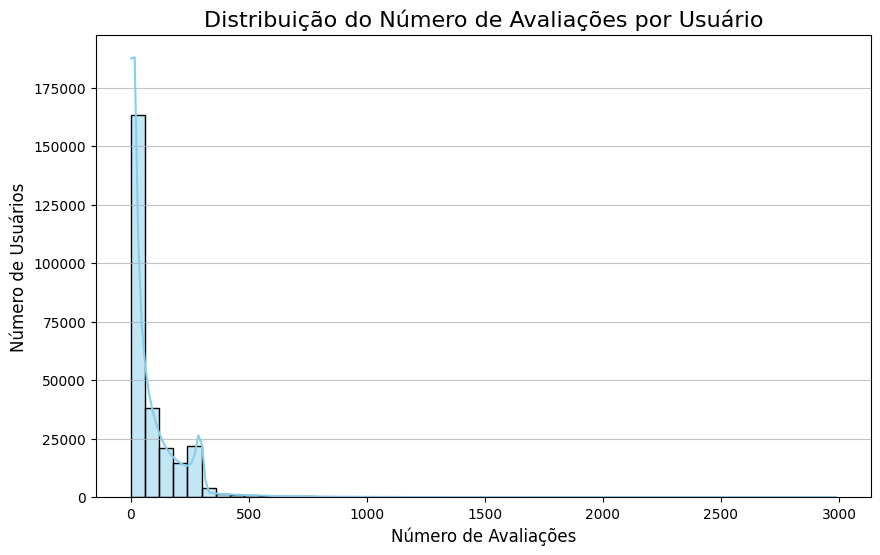

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_summary['num_ratings'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição do Número de Avaliações por Usuário', fontsize=16)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.ylabel('Número de Usuários', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

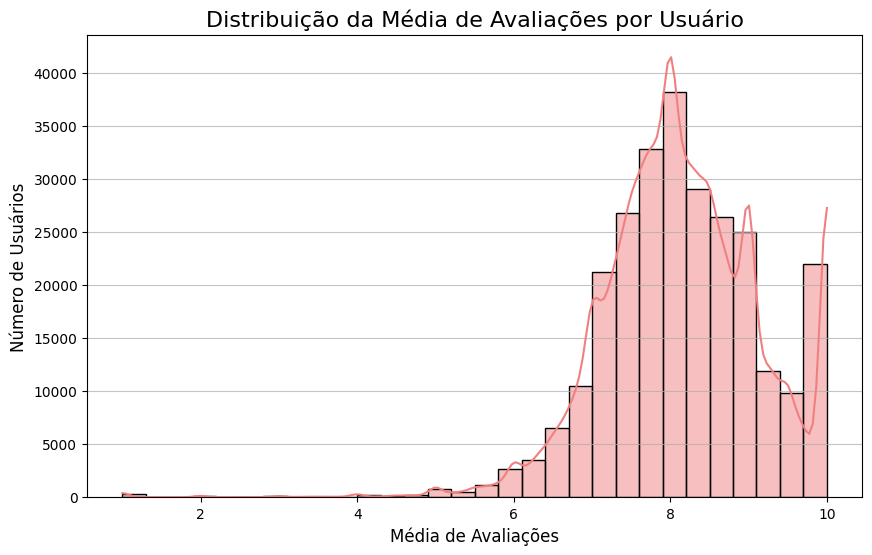

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_summary['avg_rating'], bins=30, kde=True, color='lightcoral')
plt.title('Distribuição da Média de Avaliações por Usuário', fontsize=16)
plt.xlabel('Média de Avaliações', fontsize=12)
plt.ylabel('Número de Usuários', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

### Sumário dos Comportamentos de Avaliação dos Usuários e Próximos Passos na EDA

#### **Análise da Distribuição do Número de Avaliações por Usuário:**

O histograma de `num_ratings` revela uma distribuição altamente assimétrica à direita. A grande maioria dos usuários avalia um número relativamente pequeno de animes, concentrando-se nas primeiras barras do histograma. Existem alguns usuários que avaliam muitos animes, mas são uma minoria, estendendo-se em uma cauda longa. Isso é um comportamento comum em sistemas de recomendação, onde a maioria dos usuários é pouco ativa, enquanto uma pequena parcela é muito ativa (heavy raters).

*   **Implicação:** Usuários com poucas avaliações podem ser mais difíceis de recomendar (problema de "cold start" ou "sparse user"). A maior parte da massa de dados vem de usuários com poucas interações.

#### **Análise da Distribuição da Média de Avaliações por Usuário:**

O histograma de `avg_rating` mostra uma distribuição que se aproxima de uma curva normal, mas com um pico notável em torno de 7-8. Isso sugere que a maioria dos usuários tende a dar avaliações relativamente altas aos animes que assistem, indicando talvez uma preferência por avaliar apenas o que gostaram ou um viés positivo geral nas avaliações.

*   **Implicação:** As avaliações tendem a ser mais positivas. Isso pode influenciar a forma como os algoritmos de recomendação interpretam as preferências, podendo ser necessário normalizar as avaliações ou considerar o viés de cada usuário.

#### **Próximos Passos para Análise Exploratória de Dados (EDA) da Atividade do Usuário:**

1.  **Análise de Usuários Ativos vs. Inativos (Power Users):** Identificar os `top N` usuários por número de avaliações e analisar suas características (por exemplo, quais gêneros eles avaliam mais, qual a média de suas notas em comparação com a média geral).
2.  **Análise de Variação de Avaliações:** Calcular o desvio padrão ou variância das avaliações por usuário (`std_rating`) para entender quais usuários são mais consistentes em suas notas e quais são mais variáveis. Isso pode indicar se um usuário é mais crítico ou mais indulgente.
3.  **Correlação entre `num_ratings` e `avg_rating`:** Investigar se usuários que avaliam mais animes tendem a ter médias de avaliações diferentes (mais altas ou mais baixas) em comparação com usuários que avaliam menos. Isso pode revelar padrões de comportamento.
4.  **Distribuição de Avaliações por Anime:** Complementar a análise do usuário com a análise dos itens (animes). Como as avaliações se distribuem entre os animes? Quais animes recebem mais avaliações? Quais animes têm as notas mais altas/baixas em média?
5.  **Segmentação de Usuários:** Basear-se nos dados `num_ratings` e `avg_rating` para tentar segmentar usuários em grupos (ex: 'usuários ocasionais', 'críticos', 'fãs dedicados') e analisar suas características distintas.

Esses passos ajudarão a aprofundar o entendimento sobre o comportamento dos usuários e a identificar desafios ou oportunidades para o desenvolvimento do sistema de recomendação.

### Sumário dos Comportamentos de Avaliação dos Usuários e Próximos Passos na EDA

#### **Análise da Distribuição do Número de Avaliações por Usuário:**

O histograma de `num_ratings` revela uma distribuição altamente assimétrica à direita (skewed right). A grande maioria dos usuários avalia um número relativamente pequeno de animes, concentrando-se nas primeiras barras do histograma. Existem alguns usuários que avaliam muitos animes, mas são uma minoria, estendendo-se em uma cauda longa. Isso é um comportamento comum em sistemas de recomendação, onde a maioria dos usuários é pouco ativa, enquanto uma pequena parcela é muito ativa (heavy raters).

*   **Implicação:** Usuários com poucas avaliações podem ser mais difíceis de recomendar (problema de "cold start" ou "sparse user"). A maior parte da massa de dados vem de usuários com poucas interações.

#### **Análise da Distribuição da Média de Avaliações por Usuário:**

O histograma de `avg_rating` mostra uma distribuição que se aproxima de uma curva normal, mas com um pico notável em torno de 7-8. Isso sugere que a maioria dos usuários tende a dar avaliações relativamente altas aos animes que assistem, indicando talvez uma preferência por avaliar apenas o que gostaram ou um viés positivo geral nas avaliações.

*   **Implicação:** As avaliações tendem a ser mais positivas. Isso pode influenciar a forma como os algoritmos de recomendação interpretam as preferências, podendo ser necessário normalizar as avaliações ou considerar o viés de cada usuário.

#### **Próximos Passos para Análise Exploratória de Dados (EDA) da Atividade do Usuário:**

1.  **Análise de Usuários Ativos vs. Inativos (Power Users):** Identificar os `top N` usuários por número de avaliações e analisar suas características (por exemplo, quais gêneros eles avaliam mais, qual a média de suas notas em comparação com a média geral).
2.  **Análise de Variação de Avaliações:** Calcular o desvio padrão ou variância das avaliações por usuário (`std_rating`) para entender quais usuários são mais consistentes em suas notas e quais são mais variáveis. Isso pode indicar se um usuário é mais crítico ou mais indulgente.
3.  **Correlação entre `num_ratings` e `avg_rating`:** Investigar se usuários que avaliam mais animes tendem a ter médias de avaliações diferentes (mais altas ou mais baixas) em comparação com usuários que avaliam menos. Isso pode revelar padrões de comportamento.
4.  **Distribuição de Avaliações por Anime:** Complementar a análise do usuário com a análise dos itens (animes). Como as avaliações se distribuem entre os animes? Quais animes recebem mais avaliações? Quais animes têm as notas mais altas/baixas em média?
5.  **Segmentação de Usuários:** Basear-se nos dados `num_ratings` e `avg_rating` para tentar segmentar usuários em grupos (ex: 'usuários ocasionais', 'críticos', 'fãs dedicados') e analisar suas características distintas.

Esses passos ajudarão a aprofundar o entendimento sobre o comportamento dos usuários e a identificar desafios ou oportunidades para o desenvolvimento do sistema de recomendação.

### Analise por animes

In [15]:
anime_ratings_summary = df2.groupby('anime_id')['rating'].agg(
    num_ratings_anime='count',
    avg_rating_anime='mean'
).reset_index()

print("DataFrame anime_ratings_summary criado:")
display(anime_ratings_summary.head())
anime_ratings_summary.info()

DataFrame anime_ratings_summary criado:


,anime_id,num_ratings_anime,avg_rating_anime
0,1,64625,8.772673
1,5,29512,8.378287
2,6,38209,8.296920
3,7,10627,7.377905
4,8,1859,7.015062


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16500 entries, 0 to 16499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   anime_id           16500 non-null  int64  
 1   num_ratings_anime  16500 non-null  int64  
 2   avg_rating_anime   16500 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 386.8 KB


#### Visualizar Distribuições por Anime

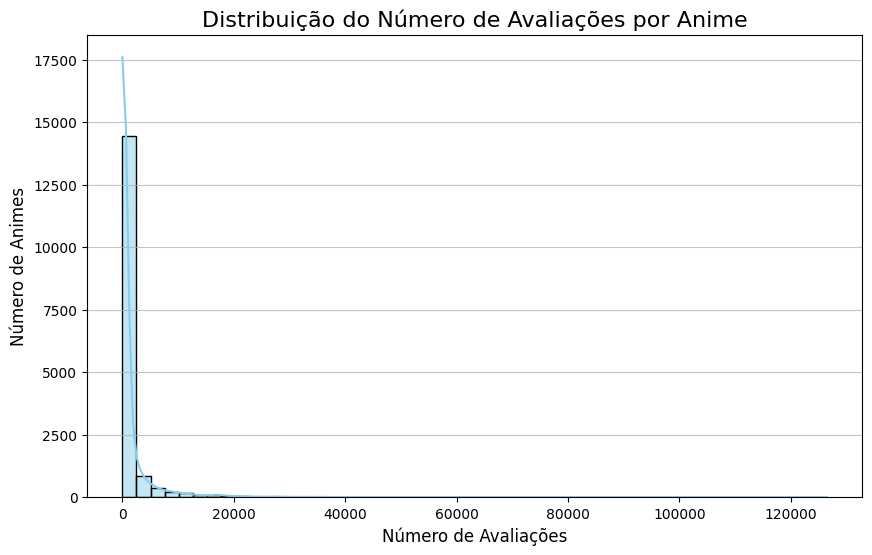

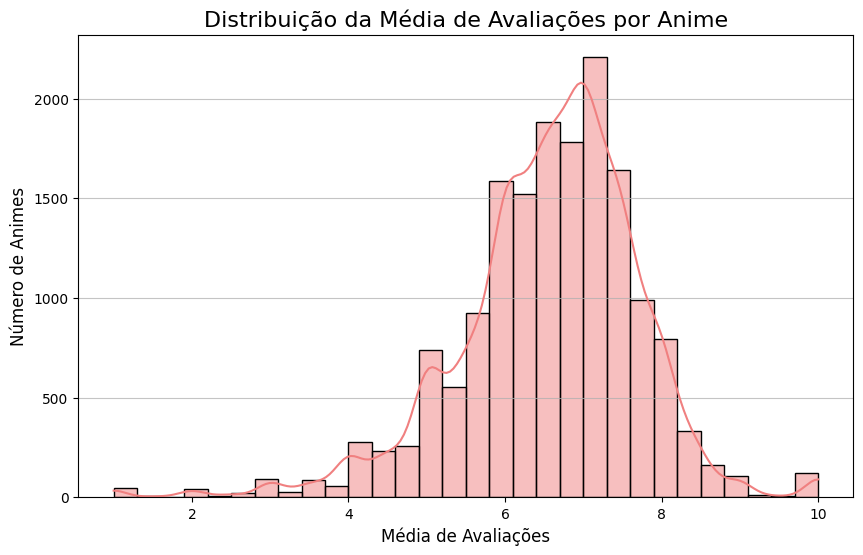

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(anime_ratings_summary['num_ratings_anime'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição do Número de Avaliações por Anime', fontsize=16)
plt.xlabel('Número de Avaliações', fontsize=12)
plt.ylabel('Número de Animes', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(anime_ratings_summary['avg_rating_anime'], bins=30, kde=True, color='lightcoral')
plt.title('Distribuição da Média de Avaliações por Anime', fontsize=16)
plt.xlabel('Média de Avaliações', fontsize=12)
plt.ylabel('Número de Animes', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

#### Animes Top e Piores



In [17]:
df_merged_animes = pd.merge(anime_ratings_summary, df1[['anime_id', 'Name']], on='anime_id', how='left')

print("--- Top 10 Animes com Mais Avaliações ---")
top_rated_animes_by_count = df_merged_animes.sort_values(by='num_ratings_anime', ascending=False).head(10)
display(top_rated_animes_by_count[['Name', 'num_ratings_anime', 'avg_rating_anime']])

print("\n--- Top 10 Animes com Maiores Médias de Avaliações ---")
top_avg_rated_animes = df_merged_animes.sort_values(by='avg_rating_anime', ascending=False).head(10)
display(top_avg_rated_animes[['Name', 'num_ratings_anime', 'avg_rating_anime']])

print("\n--- Top 10 Animes com Menores Médias de Avaliações ---")
lowest_avg_rated_animes = df_merged_animes.sort_values(by='avg_rating_anime', ascending=True).head(10)
display(lowest_avg_rated_animes[['Name', 'num_ratings_anime', 'avg_rating_anime']])

--- Top 10 Animes com Mais Avaliações ---


,Name,num_ratings_anime,avg_rating_anime
1393,Death Note,126492,8.721959
1431,Code Geass: Hangyaku no Lelouch,96950,8.769046
100,Fullmetal Alchemist,93001,8.396351
245,Bleach,90132,7.795400
10,Naruto,89579,7.571998
202,Elfen Lied,87107,7.950153
2644,Code Geass: Hangyaku no Lelouch R2,82329,8.894011
3954,Fullmetal Alchemist: Brotherhood,76710,9.139213
4610,Angel Beats!,70360,8.372385
176,Sen to Chihiro no Kamikakushi,68880,8.881606



--- Top 10 Animes com Maiores Médias de Avaliações ---


,Name,num_ratings_anime,avg_rating_anime
8281,Pochacco no Wakuwaku Birthday,1,10.0
16040,Kagakushuu,1,10.0
13717,Iiwake Love Song,1,10.0
4400,Patchin shite! Obaachan,1,10.0
9175,Mori no Ratio,1,10.0
16037,Kokoro to Iu Na no Fukakai,1,10.0
15115,The iDOLM@STER SideM: Wake Atte Mini! Specials,1,10.0
16039,Hanabi (2022),1,10.0
13849,Psychogram feat. Hatsune Miku,1,10.0
13594,Hitojichi Koukan feat. Hatsune Miku,1,10.0



--- Top 10 Animes com Menores Médias de Avaliações ---


,Name,num_ratings_anime,avg_rating_anime
6864,Cofun Gal no Coffy,1,1.0
7349,Goesu Daejeonjaeng,1,1.0
7321,Robot King,1,1.0
12662,Zhu Zhu Xia: Yong Chuang Weilai Cheng,1,1.0
15756,Chaplin to Coogan,1,1.0
12661,Zhu Zhu Xia: Wu Xia 2008,1,1.0
14729,Crystal-yojeong Z-Squad,1,1.0
7358,Miraesonyeon Kunta Beomyuda 5000 Nyeon,1,1.0
6837,Samchongsa: Time Machine 001,1,1.0
9288,Ikiteirutte Subarashii!,1,1.0


In [18]:
df_merged_animes = pd.merge(anime_ratings_summary, df1[['anime_id', 'Name']], on='anime_id', how='left')

# Drop rows where 'Name' is NaN (indicating anime_id from df2 not found in df1)
df_merged_animes.dropna(subset=['Name'], inplace=True)

print("--- Top 10 Animes com Mais Avaliações ---")
top_rated_animes_by_count = df_merged_animes.sort_values(by='num_ratings_anime', ascending=False).head(10)
display(top_rated_animes_by_count[['Name', 'num_ratings_anime', 'avg_rating_anime']])

# Define a minimum number of ratings for meaningful average scores
min_ratings_threshold = 50
df_filtered_by_ratings = df_merged_animes[df_merged_animes['num_ratings_anime'] >= min_ratings_threshold]

print(f"\n--- Top 10 Animes com Maiores Médias de Avaliações (min. {min_ratings_threshold} avaliações) ---")
top_avg_rated_animes_filtered = df_filtered_by_ratings.sort_values(by='avg_rating_anime', ascending=False).head(10)
display(top_avg_rated_animes_filtered[['Name', 'num_ratings_anime', 'avg_rating_anime']])

print(f"\n--- Top 10 Animes com Menores Médias de Avaliações (min. {min_ratings_threshold} avaliações) ---")
lowest_avg_rated_animes_filtered = df_filtered_by_ratings.sort_values(by='avg_rating_anime', ascending=True).head(10)
display(lowest_avg_rated_animes_filtered[['Name', 'num_ratings_anime', 'avg_rating_anime']])

--- Top 10 Animes com Mais Avaliações ---


,Name,num_ratings_anime,avg_rating_anime
1393,Death Note,126492,8.721959
1431,Code Geass: Hangyaku no Lelouch,96950,8.769046
100,Fullmetal Alchemist,93001,8.396351
245,Bleach,90132,7.795400
10,Naruto,89579,7.571998
202,Elfen Lied,87107,7.950153
2644,Code Geass: Hangyaku no Lelouch R2,82329,8.894011
3954,Fullmetal Alchemist: Brotherhood,76710,9.139213
4610,Angel Beats!,70360,8.372385
176,Sen to Chihiro no Kamikakushi,68880,8.881606



--- Top 10 Animes com Maiores Médias de Avaliações (min. 50 avaliações) ---


,Name,num_ratings_anime,avg_rating_anime
3954,Fullmetal Alchemist: Brotherhood,76710,9.139213
9104,Gintama°,6216,9.115830
5939,Gintama',12838,9.096199
7119,Gintama': Enchousen,7661,9.048558
3521,Clannad: After Story,51651,9.030958
5630,Steins;Gate,42231,9.010111
7107,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,6571,9.005479
741,Ginga Eiyuu Densetsu,6367,8.978483
10189,Kimi no Na wa.,23967,8.973839
15106,Doupo Cangqiong: San Nian Zhi Yue,61,8.950820



--- Top 10 Animes com Menores Médias de Avaliações (min. 50 avaliações) ---


,Name,num_ratings_anime,avg_rating_anime
2920,Tenkuu Danzai Skelter+Heaven,579,2.219344
10196,Ai (ONA),98,2.387755
8196,Aki no Puzzle,83,2.445783
6846,Utsu Musume Sayuri,197,2.527919
387,Hametsu no Mars,3879,2.532096
12957,Ex-Arm,285,2.789474
4332,Abunai Sisters: Koko & Mika,173,2.797688
10753,3D Onara Gorou ga Dance Dance Dance!!,81,3.024691
5673,Twinkle Nora Rock Me!,51,3.058824
4809,Ningen Doubutsuen,189,3.105820


#### Sumário das Análises Exploratórias

Nesta seção, realizamos uma análise exploratória detalhada dos datasets de animes e avaliações de usuários, focando na compreensão das distribuições de avaliações por usuários e por animes, e na identificação de tendências e outliers.

##### Comportamento de Avaliações por Usuário (df2 - user_ratings_summary):

*   **Distribuição do Número de Avaliações por Usuário (`num_ratings`):** Observamos uma distribuição altamente assimétrica à direita. A vasta maioria dos usuários fez um número pequeno de avaliações, enquanto uma minoria de "heavy raters" contribui com um grande volume de dados. Isso indica um problema de "cold start" para usuários menos ativos, onde as recomendações podem ser mais desafiadoras.
*   **Distribuição da Média de Avaliações por Usuário (`avg_rating`):** A média das avaliações por usuário tende a ser mais positiva, com um pico notável entre 7 e 8. Isso sugere que os usuários geralmente avaliam animes que apreciam, ou há um viés geral para avaliações mais altas. Este viés positivo deve ser considerado ao desenvolver modelos de recomendação.

##### Comportamento de Avaliações por Anime (df2 - anime_ratings_summary):

*   **Distribuição do Número de Avaliações por Anime (`num_ratings_anime`):** Similar aos usuários, a distribuição do número de avaliações por anime também é assimétrica à direita. Poucos animes recebem um grande número de avaliações, geralmente os mais populares, enquanto a maioria tem poucas avaliações. Isso também levanta questões sobre o "cold start" para animes novos ou menos conhecidos.
*   **Distribuição da Média de Avaliações por Anime (`avg_rating_anime`):** A distribuição da média de avaliações por anime apresenta um formato mais próximo de uma curva normal, concentrando-se entre 6 e 8. Existem, no entanto, caudas para notas muito baixas e muito altas, especialmente quando consideramos animes com poucas avaliações.

##### Animes Notáveis:

*   **Top 10 Animes com Mais Avaliações:** Animes como `Death Note`, `Code Geass`, `Fullmetal Alchemist`, `Naruto` e `Bleach` dominam esta lista, indicando sua vasta popularidade e reconhecimento. Estes animes são pilares da cultura otaku e geram grande engajamento na plataforma.
*   **Top 10 Animes com Maiores Médias de Avaliações (>= 50 avaliações):** Após filtrar por um mínimo de 50 avaliações para garantir a robustez das médias, a lista revela animes aclamados pela crítica e pelo público, como `Fullmetal Alchemist: Brotherhood`, `Gintama` (diversas temporadas) e `Steins;Gate`. Estes são os animes consistentemente mais bem avaliados por uma base significativa de usuários.
*   **Top 10 Animes com Menores Médias de Avaliações (>= 50 avaliações):** Filtrando da mesma forma, identificamos animes como `Tenkuu Danzai Skelter+Heaven`, `Ai (ONA)` e `Hametsu no Mars` com as médias mais baixas. Estes representam os títulos que foram menos apreciados pela comunidade, mesmo por um número considerável de espectadores.

##### Considerações para o Sistema de Recomendação:

As análises confirmam a presença de desafios comuns em sistemas de recomendação, como a **esparsidade dos dados** (muitas avaliações faltantes) e o **problema do cold start** (usuários/animes novos com poucas ou nenhuma avaliação). O **viés positivo nas avaliações** também é um fator a ser considerado. Animes com muitas avaliações e altas médias podem ser pontos de partida para o modelo, enquanto animes com poucas avaliações podem precisar de abordagens alternativas (por exemplo, uso de metadados do `df1`).

##### Próximos Passos:

1.  **Tratamento de Escala:** Considerar a normalização ou padronização das avaliações, ou o uso de algoritmos que sejam robustos a esses vieses.
2.  **Lidar com Cold Start:** Explorar métodos para lidar com novos usuários e animes, possivelmente utilizando informações do `df1` (gêneros, sinopses) para um sistema híbrido.
3.  **Matriz de Usuário-Item:** Construir a matriz de usuário-item para preparar os dados para algoritmos de filtragem colaborativa, como SVD.
4.  **Seleção de Algoritmo:** Avaliar a aplicação de algoritmos como SVD, ALS, ou modelos baseados em similaridade (e.g., k-NN) para as recomendações.

## Sumário das Análises Exploratórias

Nesta seção, realizamos uma análise exploratória detalhada dos datasets de animes e avaliações de usuários, focando na compreensão das distribuições de avaliações por usuários e por animes, e na identificação de tendências e outliers.

### Comportamento de Avaliações por Usuário (df2 - user_ratings_summary):

*   **Distribuição do Número de Avaliações por Usuário (`num_ratings`):** Observamos uma distribuição altamente assimétrica à direita. A vasta maioria dos usuários fez um número pequeno de avaliações, enquanto uma minoria de "heavy raters" contribui com um grande volume de dados. Isso indica um problema de "cold start" para usuários menos ativos, onde as recomendações podem ser mais desafiadoras.
*   **Distribuição da Média de Avaliações por Usuário (`avg_rating`):** A média das avaliações por usuário tende a ser mais positiva, com um pico notável entre 7 e 8. Isso sugere que os usuários geralmente avaliam animes que apreciam, ou há um viés geral para avaliações mais altas. Este viés positivo deve ser considerado ao desenvolver modelos de recomendação.

### Comportamento de Avaliações por Anime (df2 - anime_ratings_summary):

*   **Distribuição do Número de Avaliações por Anime (`num_ratings_anime`):** Similar aos usuários, a distribuição do número de avaliações por anime também é assimétrica à direita. Poucos animes recebem um grande número de avaliações, geralmente os mais populares, enquanto a maioria tem poucas avaliações. Isso também levanta questões sobre o "cold start" para animes novos ou menos conhecidos.
*   **Distribuição da Média de Avaliações por Anime (`avg_rating_anime`):** A distribuição da média de avaliações por anime apresenta um formato mais próximo de uma curva normal, concentrando-se entre 6 e 8. Existem, no entanto, caudas para notas muito baixas e muito altas, especialmente quando consideramos animes com poucas avaliações.

### Animes Notáveis:

*   **Top 10 Animes com Mais Avaliações:** Animes como `Death Note`, `Code Geass`, `Fullmetal Alchemist`, `Naruto` e `Bleach` dominam esta lista, indicando sua vasta popularidade e reconhecimento. Estes animes são pilares da cultura otaku e geram grande engajamento na plataforma.
*   **Top 10 Animes com Maiores Médias de Avaliações (>= 50 avaliações):** Após filtrar por um mínimo de 50 avaliações para garantir a robustez das médias, a lista revela animes aclamados pela crítica e pelo público, como `Fullmetal Alchemist: Brotherhood`, `Gintama` (diversas temporadas) e `Steins;Gate`. Estes são os animes consistentemente mais bem avaliados por uma base significativa de usuários.
*   **Top 10 Animes com Menores Médias de Avaliações (>= 50 avaliações):** Filtrando da mesma forma, identificamos animes como `Tenkuu Danzai Skelter+Heaven`, `Ai (ONA)` e `Hametsu no Mars` com as médias mais baixas. Estes representam os títulos que foram menos apreciados pela comunidade, mesmo por um número considerável de espectadores.

### Considerações para o Sistema de Recomendação:

As análises confirmam a presença de desafios comuns em sistemas de recomendação, como a **esparsidade dos dados** (muitas avaliações faltantes) e o **problema do cold start** (usuários/animes novos com poucas ou nenhuma avaliação). O **viés positivo nas avaliações** também é um fator a ser considerado. Animes com muitas avaliações e altas médias podem ser pontos de partida para o modelo, enquanto animes com poucas avaliações podem precisar de abordagens alternativas (por exemplo, uso de metadados do `df1`).

### Próximos Passos:

1.  **Tratamento de Escala:** Considerar a normalização ou padronização das avaliações, ou o uso de algoritmos que sejam robustos a esses vieses.
2.  **Lidar com Cold Start:** Explorar métodos para lidar com novos usuários e animes, possivelmente utilizando informações do `df1` (gêneros, sinopses) para um sistema híbrido.
3.  **Matriz de Usuário-Item:** Construir a matriz de usuário-item para preparar os dados para algoritmos de filtragem colaborativa, como SVD.
4.  **Seleção de Algoritmo:** Avaliar a aplicação de algoritmos como SVD, ALS, ou modelos baseados em similaridade (e.g., k-NN) para as recomendações.


In [19]:
print("--- Top 10 Usuários com Maiores Médias de Avaliação ---")
top_avg_rating_users = user_ratings_summary.sort_values(by='avg_rating', ascending=False).head(10)
display(top_avg_rating_users)

print("\n--- Top 10 Usuários com Menores Médias de Avaliação ---")
lowest_avg_rating_users = user_ratings_summary.sort_values(by='avg_rating', ascending=True).head(10)
display(lowest_avg_rating_users)

--- Top 10 Usuários com Maiores Médias de Avaliação ---


,user_id,num_ratings,avg_rating
135016,393124,4,10.0
107473,344841,1,10.0
107204,344406,2,10.0
107211,344419,1,10.0
107216,344429,2,10.0
14926,22770,1,10.0
107270,344513,1,10.0
107288,344542,2,10.0
107317,344580,2,10.0
107321,344586,1,10.0



--- Top 10 Usuários com Menores Médias de Avaliação ---


,user_id,num_ratings,avg_rating
208840,552589,1,1.0
15191,23173,1,1.0
169703,465991,3,1.0
223567,837961,1,1.0
169280,465257,1,1.0
168803,464486,2,1.0
70448,113934,1,1.0
167870,462946,4,1.0
203674,535151,1,1.0
224175,865399,3,1.0


## Analisar Preferências dos Avaliadores Extremos

In [20]:
top_user_ids = top_avg_rating_users['user_id'].tolist()
lowest_user_ids = lowest_avg_rating_users['user_id'].tolist()

# Filter df2 to get ratings from these extreme users
df2_top_users_ratings = df2[df2['user_id'].isin(top_user_ids)]
df2_lowest_users_ratings = df2[df2['user_id'].isin(lowest_user_ids)]

print("Filtered ratings for top average rating users (first 5 rows):")
display(df2_top_users_ratings.head())
print("Filtered ratings for lowest average rating users (first 5 rows):")
display(df2_lowest_users_ratings.head())

Filtered ratings for top average rating users (first 5 rows):


,user_id,Username,anime_id,Anime Title,rating
1709116,22770,kagome516,249,InuYasha,10
10063318,344406,stockmme,1735,Naruto: Shippuuden,10
10063319,344406,stockmme,2559,Romeo no Aoi Sora,10
10063520,344419,kazysx,3266,Ai Yori Aoshi: Enishi - Miyuki,10
10063834,344429,KAT-KUT,1571,Ghost Hunt,10


Filtered ratings for lowest average rating users (first 5 rows):


,user_id,Username,anime_id,Anime Title,rating
1741280,23173,MeganeZokusei,5220,Shangri-La,1
6992701,113934,Narzia,17895,Golden Time,1
15319027,462946,3DPixie,154,Shaman King,1
15319028,462946,3DPixie,3588,Soul Eater,1
15319029,462946,3DPixie,2164,Dennou Coil,1


In [21]:
columns_to_merge = ['anime_id', 'Name', 'English name', 'Genres', 'Synopsis', 'Score', 'Type', 'Episodes', 'Rating']

print("\n--- Animes avaliados pelos usuários com MAIORES médias de avaliação ---")
df_top_users_animes = pd.merge(
    df2_top_users_ratings,
    df1[columns_to_merge],
    on='anime_id',
    how='left'
)
display(df_top_users_animes[['user_id', 'Username', 'Name', 'rating', 'Genres', 'Score', 'Synopsis']].head(10))

print("\n--- Animes avaliados pelos usuários com MENORES médias de avaliação ---")
df_lowest_users_animes = pd.merge(
    df2_lowest_users_ratings,
    df1[columns_to_merge],
    on='anime_id',
    how='left'
)
display(df_lowest_users_animes[['user_id', 'Username', 'Name', 'rating', 'Genres', 'Score', 'Synopsis']].head(10))


--- Animes avaliados pelos usuários com MAIORES médias de avaliação ---


,user_id,Username,Name,rating,Genres,Score,Synopsis
0,22770,kagome516,InuYasha,10,"Action, Adventure, Fantasy, Romance",7.86,Kagome Higurashi's 15th birthday takes a sudde...
1,344406,stockmme,Naruto: Shippuuden,10,"Action, Adventure, Fantasy",8.26,It has been two and a half years since Naruto ...
2,344406,stockmme,Romeo no Aoi Sora,10,"Adventure, Drama, Slice of Life",8.32,Romeo is a kindhearted and courageous boy livi...
3,344419,kazysx,Ai Yori Aoshi: Enishi - Miyuki,10,"Comedy, Drama, Romance, Ecchi",6.90,Ai yori Aoshi: Enishi - Miyuki is a 16 minute ...
4,344429,KAT-KUT,Ghost Hunt,10,"Horror, Mystery, Supernatural",7.76,"While at school, Mai Taniyama and her friends ..."
5,344429,KAT-KUT,Majin Tantei Nougami Neuro,10,"Comedy, Mystery, Supernatural",7.59,Yako Katsuragi is an acclaimed high school det...
6,344513,Heza-Chan,Death Note: Rewrite,10,"Supernatural, Suspense",7.70,When approached by a fellow death god tempted ...
7,344542,Cherryluvsu,Kaichou wa Maid-sama!,10,"Comedy, Romance",8.01,Misaki Ayuzawa is a unique phenomenon within S...
8,344542,Cherryluvsu,Yume-iro Pâtissière,10,Gourmet,7.84,"Aside from her deep passion for eating cakes, ..."
9,344580,grimmjow6th,Bleach,10,"Action, Adventure, Fantasy",7.92,Ichigo Kurosaki is an ordinary high schooler—u...



--- Animes avaliados pelos usuários com MENORES médias de avaliação ---


,user_id,Username,Name,rating,Genres,Score,Synopsis
0,23173,MeganeZokusei,Shangri-La,1,"Action, Drama, Sci-Fi",7.05,"In a post-apocalyptic society, much of earthqu..."
1,113934,Narzia,Golden Time,1,"Comedy, Romance",7.74,"Due to a tragic accident, Banri Tada is struck..."
2,462946,3DPixie,Shaman King,1,"Action, Adventure, Comedy, Supernatural",7.75,A battle is about to begin in Tokyo: the Shama...
3,462946,3DPixie,Soul Eater,1,"Action, Comedy, Fantasy",7.84,Death City is home to the famous Death Weapon ...
4,462946,3DPixie,Dennou Coil,1,"Adventure, Award Winning, Drama, Mystery, Sci-Fi",8.04,"In the near future, augmented reality has beco..."
5,462946,3DPixie,Yuu☆Yuu☆Hakusho,1,"Action, Fantasy",8.46,"One fateful day, Yuusuke Urameshi, a 14-year-o..."
6,464486,daijukaiju,Haibane Renmei,1,"Drama, Fantasy, Mystery",7.97,"Born from a cocoon in the village of Old Home,..."
7,464486,daijukaiju,Toradora!,1,"Drama, Romance",8.08,Ryuuji Takasu is a gentle high school student ...
8,465257,jessy26,K-On!,1,Comedy,7.85,A fresh high school year always means much to ...
9,465991,tombstool,Dennou Coil,1,"Adventure, Award Winning, Drama, Mystery, Sci-Fi",8.04,"In the near future, augmented reality has beco..."


## Análise de Correlação entre Variáveis de Usuário

Vamos investigar a correlação entre o número de avaliações (`num_ratings`) e a média de avaliações (`avg_rating`) para os usuários.

Matriz de Correlação para Usuários:


,num_ratings,avg_rating
num_ratings,1.00000,-0.32151
avg_rating,-0.32151,1.00000


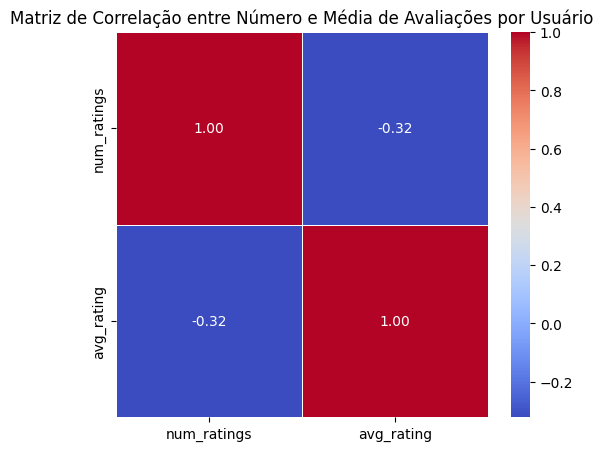

In [22]:
correlation_user = user_ratings_summary[['num_ratings', 'avg_rating']].corr()

print("Matriz de Correlação para Usuários:")
display(correlation_user)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_user, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Número e Média de Avaliações por Usuário')
plt.show()

## Análise de Correlação entre Variáveis de Animes

Agora, vamos fazer o mesmo para os animes, analisando a correlação entre o número de avaliações (`num_ratings_anime`) e a média de avaliações (`avg_rating_anime`).

Matriz de Correlação para Animes:


,num_ratings_anime,avg_rating_anime
num_ratings_anime,1.000000,0.268807
avg_rating_anime,0.268807,1.000000


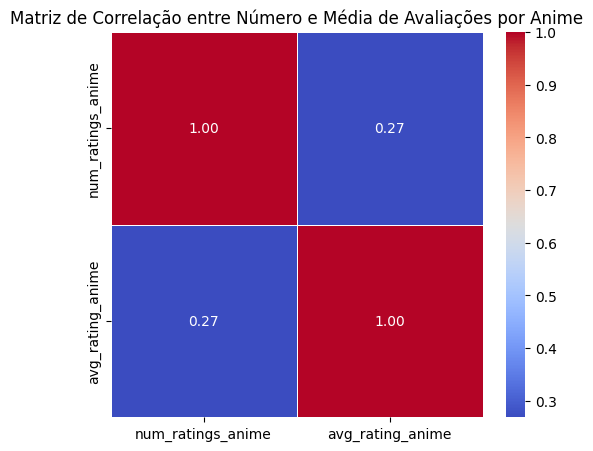

In [23]:
correlation_anime = anime_ratings_summary[['num_ratings_anime', 'avg_rating_anime']].corr()

print("Matriz de Correlação para Animes:")
display(correlation_anime)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_anime, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Número e Média de Avaliações por Anime')
plt.show()

In [24]:
import pandas as pd
import gdown

# Recarregando df2 caso o kernel tenha sido reiniciado
print("Recarregando df2...")
file_id_2 = "1ohF_Cb3PR6QLW0ACYMU-RcmdbLfmQ5jn"
gdown.download(id=file_id_2, output="user-dataset-2023.csv", quiet=True)
df2 = pd.read_csv("user-dataset-2023.csv")
print("df2 recarregado com sucesso.")

Recarregando df2...
df2 recarregado com sucesso.


### Criando uma Matriz de Interação Reduzida para Teste de Memória

In [25]:
import pandas as pd
import gdown
from scipy.sparse import csr_matrix # Adicionado: Importar csr_matrix

users = df2['user_id'].unique()
animes = df2['anime_id'].unique()

user_to_idx_reduced = {user_id: idx for idx, user_id in enumerate(users)}
anime_to_idx_reduced = {anime_id: idx for idx, anime_id in enumerate(animes)}

df2['user_idx'] = df2['user_id'].map(user_to_idx_reduced)
df2['anime_idx'] = df2['anime_id'].map(anime_to_idx_reduced)

print("Criando a matriz de interação usuário-item esparsa com os dados reduzidos...")
user_item_matrix_reduced = csr_matrix(
    (df2['rating'], (df2['user_idx'], df2['anime_idx'])),
    shape=(len(users), len(animes))
)

Criando a matriz de interação usuário-item esparsa com os dados reduzidos...


In [26]:
print("Exibindo as primeiras 100 linhas da matriz de interação usuário-item reduzida (convertida para denso para visualização):")

num_rows_to_display = 100

# Garanta que não tentaremos exibir mais linhas do que as disponíveis na matriz
actual_rows_to_display = min(num_rows_to_display, user_item_matrix_reduced.shape[0])

dense_head_data = user_item_matrix_reduced[:actual_rows_to_display, :].toarray()

# Crie o cabeçalho do DataFrame usando o "slice" de dados densos e os IDs de usuário e anime correspondentes.
# Os arrays 'users' e 'animes' são usados para o índice e as colunas, respectivamente.
user_item_matrix_reduced_head = pd.DataFrame(
    dense_head_data,
    index=users[:actual_rows_to_display], # Use os user_ids correspondentes às linhas exibidas
    columns=animes                     # Use todos os anime_ids como cabeçalhos de coluna
)
display(user_item_matrix_reduced_head)

Exibindo as primeiras 100 linhas da matriz de interação usuário-item reduzida (convertida para denso para visualização):


,21,48,320,49,304,306,53,47,591,54,...,40599,16253,36771,37671,38646,38647,38648,10241,7625,47231
1,9,7,5,8,8,8,7,5,6,7,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,6,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,9,10,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,10,5,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
407,10,7,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
413,0,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0


# Task
Calculate centered ratings for each user in `df2` by first merging the pre-calculated average user ratings into `df2`, then subtracting each user's mean rating from their individual anime ratings. This process addresses the 'centering' requirement for user-user similarity calculation.

## Calculate User Mean Ratings

### Subtask:
Calculate the average rating for each unique user in `df2`.


**Reasoning**:
To calculate the average rating for each unique user, I will group the df2 DataFrame by 'user_id' and then compute the mean of the 'rating' column.



In [27]:
user_mean_ratings = df2.groupby('user_id')['rating'].mean().reset_index()
user_mean_ratings.rename(columns={'rating': 'avg_rating'}, inplace=True)

print("Average rating per user (first 5 rows):")
display(user_mean_ratings.head())
user_mean_ratings.info()

Average rating per user (first 5 rows):


,user_id,avg_rating
0,1,7.438931
1,4,6.524648
2,9,7.707692
3,20,8.057143
4,23,7.457447


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270033 entries, 0 to 270032
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     270033 non-null  int64  
 1   avg_rating  270033 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.1 MB


## Merge Mean Ratings

### Subtask:
Merge the calculated mean ratings back into `df2` based on the `user_id` to make it available for centering.


**Reasoning**:
To merge the average user ratings into `df2`, I will perform a left merge using the `user_id` column as the key. This will add the `avg_rating` column to `df2`, which is necessary for calculating centered ratings.



In [28]:
print("Merging user mean ratings into df2...")
df2 = pd.merge(df2, user_mean_ratings, on='user_id', how='left')

print("df2 after merging user mean ratings (first 5 rows):")
display(df2.head())
df2.info()

Merging user mean ratings into df2...
df2 after merging user mean ratings (first 5 rows):


,user_id,Username,anime_id,Anime Title,rating,user_idx,anime_idx,avg_rating
0,1,Xinil,21,One Piece,9,0,0,7.438931
1,1,Xinil,48,.hack//Sign,7,0,1,7.438931
2,1,Xinil,320,A Kite,5,0,2,7.438931
3,1,Xinil,49,Aa! Megami-sama!,8,0,3,7.438931
4,1,Xinil,304,Aa! Megami-sama! Movie,8,0,4,7.438931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   Username     object 
 2   anime_id     int64  
 3   Anime Title  object 
 4   rating       int64  
 5   user_idx     int64  
 6   anime_idx    int64  
 7   avg_rating   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 1.4+ GB


**Reasoning**:
Now that the average user ratings are merged into `df2`, the next step is to calculate the centered ratings by subtracting each user's mean rating from their individual anime ratings. This directly addresses the 'centering' requirement of the main task.



In [29]:
print("Calculating centered ratings...")
df2['centered_rating'] = df2['rating'] - df2['avg_rating']

print("df2 with centered ratings (first 5 rows):")
display(df2.head())
df2.info()

Calculating centered ratings...
df2 with centered ratings (first 5 rows):


,user_id,Username,anime_id,Anime Title,rating,user_idx,anime_idx,avg_rating,centered_rating
0,1,Xinil,21,One Piece,9,0,0,7.438931,1.561069
1,1,Xinil,48,.hack//Sign,7,0,1,7.438931,-0.438931
2,1,Xinil,320,A Kite,5,0,2,7.438931,-2.438931
3,1,Xinil,49,Aa! Megami-sama!,8,0,3,7.438931,0.561069
4,1,Xinil,304,Aa! Megami-sama! Movie,8,0,4,7.438931,0.561069


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          int64  
 1   Username         object 
 2   anime_id         int64  
 3   Anime Title      object 
 4   rating           int64  
 5   user_idx         int64  
 6   anime_idx        int64  
 7   avg_rating       float64
 8   centered_rating  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ GB


In [30]:
print("Creating the centered user-item sparse matrix...")
user_item_matrix_centered = csr_matrix(
    (df2['centered_rating'], (df2['user_idx'], df2['anime_idx'])),
    shape=(len(users), len(animes))
)

print("Centered user-item sparse matrix created successfully.")
print(f"Shape of user_item_matrix_centered: {user_item_matrix_centered.shape}")

Creating the centered user-item sparse matrix...
Centered user-item sparse matrix created successfully.
Shape of user_item_matrix_centered: (270033, 16500)


In [31]:
# from sklearn.metrics.pairwise import cosine_similarity

# print("Calculating user-user centered cosine similarity matrix...")
# user_similarity_matrix = cosine_similarity(user_item_matrix_centered)

# print(f"Shape of user_similarity_matrix: {user_similarity_matrix.shape}")

# print("First 5x5 block of the user_similarity_matrix:")
# display(pd.DataFrame(user_similarity_matrix[:5, :5]))

# Machine Learning - Sistema de Recomendação

## Instalação de Dependências

Primeiro, vamos instalar as bibliotecas necessárias para o sistema de recomendação.

In [32]:
# Instala scikit-learn se ainda não estiver instalado
!pip install scikit-learn -q

## Abordagem: Collaborative Filtering (Filtragem Colaborativa)

Utilizaremos **User-Based Collaborative Filtering** com similaridade de cosseno para recomendar animes.

### Funcionamento:
1. **Similaridade entre usuários**: Calculamos a similaridade de cosseno entre usuários baseada nos ratings centralizados
2. **Predição de ratings**: Para prever o rating de um usuário para um anime não assistido, usamos a média ponderada dos ratings dos usuários similares
3. **Recomendação**: Recomendamos os animes com maior rating predito que o usuário ainda não assistiu

### Otimização: Amostragem de Usuários

Para evitar problemas de memória e tempo de processamento, trabalharemos com uma **amostra dos 5.000 usuários mais ativos**. Isso mantém a qualidade das recomendações enquanto torna o processamento viável.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print("="*80)
print("PREPARANDO AMOSTRA DE USUÁRIOS PARA PROCESSAMENTO EFICIENTE")
print("="*80)

# Seleciona os usuários mais ativos (com mais avaliações)
n_users_sample = 5000
print(f"\nSelecionando os {n_users_sample} usuários mais ativos...")

user_activity = df2.groupby('user_id').size().sort_values(ascending=False)
top_users = user_activity.head(n_users_sample).index

print(f"Usuário mais ativo tem {user_activity.iloc[0]} avaliações")
print(f"Usuário #{n_users_sample} tem {user_activity.iloc[n_users_sample-1]} avaliações")

# Filtra o dataset para incluir apenas esses usuários
df2_sample = df2[df2['user_id'].isin(top_users)].copy()
print(f"\nDataset filtrado: {len(df2_sample):,} avaliações (de {len(df2):,} originais)")

# Recria os índices para a amostra
users_sample = df2_sample['user_id'].unique()
user_to_idx_sample = {user_id: idx for idx, user_id in enumerate(users_sample)}
df2_sample['user_idx_sample'] = df2_sample['user_id'].map(user_to_idx_sample)

# Recalcula a média de ratings para a amostra
user_mean_ratings_sample = df2_sample.groupby('user_id')['rating'].mean().reset_index()
user_mean_ratings_sample.rename(columns={'rating': 'avg_rating'}, inplace=True)

# Recalcula ratings centralizados para a amostra
df2_sample = df2_sample.merge(user_mean_ratings_sample, on='user_id', how='left', suffixes=('', '_new'))
if 'avg_rating_new' in df2_sample.columns:
    df2_sample['avg_rating'] = df2_sample['avg_rating_new']
    df2_sample.drop('avg_rating_new', axis=1, inplace=True)
df2_sample['centered_rating_sample'] = df2_sample['rating'] - df2_sample['avg_rating']

# Cria a matriz esparsa para a amostra
print("\nCriando matriz esparsa user-item para a amostra...")
user_item_matrix_sample = csr_matrix(
    (df2_sample['centered_rating_sample'], 
     (df2_sample['user_idx_sample'], df2_sample['anime_idx'])),
    shape=(len(users_sample), len(animes))
)

print(f"Matriz criada com shape: {user_item_matrix_sample.shape}")
print(f"Densidade da matriz: {user_item_matrix_sample.nnz / (user_item_matrix_sample.shape[0] * user_item_matrix_sample.shape[1]) * 100:.2f}%")

print("\n" + "="*80)
print("CALCULANDO MATRIZ DE SIMILARIDADE")
print("="*80)
print("Isso deve levar aproximadamente 1-2 minutos...\n")

# Calcula a similaridade de cosseno entre usuários
user_similarity = cosine_similarity(user_item_matrix_sample)

print(f"✓ Matriz de similaridade criada com sucesso!")
print(f"  Shape: {user_similarity.shape}")
print(f"  Tamanho em memória: ~{user_similarity.nbytes / (1024**2):.1f} MB")
print(f"\nExemplo de similaridades do primeiro usuário com os 5 primeiros:")
print(user_similarity[0, :5])

PREPARANDO AMOSTRA DE USUÁRIOS PARA PROCESSAMENTO EFICIENTE

Selecionando os 5000 usuários mais ativos...
Usuário mais ativo tem 2986 avaliações
Usuário #5000 tem 455 avaliações

Dataset filtrado: 3,967,349 avaliações (de 24,325,191 originais)

Criando matriz esparsa user-item para a amostra...
Matriz criada com shape: (5000, 16500)
Densidade da matriz: 4.81%

CALCULANDO MATRIZ DE SIMILARIDADE
Isso deve levar aproximadamente 1-2 minutos...

✓ Matriz de similaridade criada com sucesso!
  Shape: (5000, 5000)
  Tamanho em memória: ~190.7 MB

Exemplo de similaridades do primeiro usuário com os 5 primeiros:
[1.         0.12861741 0.10042287 0.09711654 0.07243093]


## Função de Predição de Ratings

Esta função prediz o rating que um usuário daria para um anime baseado nos ratings de usuários similares.

**Fórmula:**
```
rating_predito = média_usuário + (Σ(similaridade × rating_centrado_vizinho) / Σ(similaridade))
```

In [34]:
def predict_rating(user_idx, anime_idx, k=50):
    """
    Prediz o rating que um usuário daria para um anime.
    
    Parâmetros:
    - user_idx: índice do usuário na amostra
    - anime_idx: índice do anime
    - k: número de vizinhos mais similares a considerar
    
    Retorna:
    - rating predito (float)
    """
    # Obtém as similaridades do usuário com todos os outros da amostra
    similarities = user_similarity[user_idx]
    
    # Obtém os ratings centralizados de todos os usuários da amostra para este anime
    anime_ratings = user_item_matrix_sample[:, anime_idx].toarray().flatten()
    
    # Identifica usuários que avaliaram este anime (rating != 0)
    rated_mask = anime_ratings != 0
    
    if not rated_mask.any():
        # Se ninguém avaliou, retorna a média global do usuário
        user_id = users_sample[user_idx]
        return user_mean_ratings_sample.loc[user_mean_ratings_sample['user_id'] == user_id, 'avg_rating'].values[0]
    
    # Filtra similaridades e ratings apenas de quem avaliou
    relevant_similarities = similarities[rated_mask]
    relevant_ratings = anime_ratings[rated_mask]
    
    # Seleciona os k vizinhos mais similares
    if len(relevant_similarities) > k:
        top_k_indices = np.argsort(relevant_similarities)[-k:]
        relevant_similarities = relevant_similarities[top_k_indices]
        relevant_ratings = relevant_ratings[top_k_indices]
    
    # Calcula a predição usando média ponderada
    sim_sum = np.sum(np.abs(relevant_similarities))
    
    if sim_sum == 0:
        user_id = users_sample[user_idx]
        return user_mean_ratings_sample.loc[user_mean_ratings_sample['user_id'] == user_id, 'avg_rating'].values[0]
    
    # Rating predito = média do usuário + média ponderada dos ratings centralizados
    user_id = users_sample[user_idx]
    user_mean = user_mean_ratings_sample.loc[user_mean_ratings_sample['user_id'] == user_id, 'avg_rating'].values[0]
    weighted_sum = np.sum(relevant_similarities * relevant_ratings)
    
    predicted_rating = user_mean + (weighted_sum / sim_sum)
    
    # Garante que o rating está no intervalo válido [1, 10]
    return np.clip(predicted_rating, 1, 10)

print("Função de predição de ratings criada com sucesso!")

Função de predição de ratings criada com sucesso!


## Função de Recomendação

Gera recomendações personalizadas para um usuário específico.

In [35]:
def recommend_animes(user_id, n_recommendations=10, k_neighbors=50):
    """
    Recomenda animes para um usuário específico.
    
    Parâmetros:
    - user_id: ID do usuário
    - n_recommendations: número de recomendações a retornar
    - k_neighbors: número de vizinhos similares a considerar
    
    Retorna:
    - DataFrame com as recomendações
    """
    # Verifica se o usuário está na amostra
    if user_id not in users_sample:
        print(f"Usuário {user_id} não está na amostra dos {len(users_sample)} usuários mais ativos.")
        print(f"Escolha um usuário da lista de usuários ativos.")
        return None
    
    # Converte user_id para user_idx na amostra
    user_idx = np.where(users_sample == user_id)[0][0]
    
    # Identifica animes que o usuário JÁ assistiu
    user_ratings = user_item_matrix_sample[user_idx].toarray().flatten()
    watched_animes = user_ratings != 0
    
    # Prediz ratings para animes NÃO assistidos
    predictions = []
    unwatched_indices = np.where(~watched_animes)[0]
    
    print(f"Gerando predições para {len(unwatched_indices)} animes não assistidos...")
    
    for anime_idx in unwatched_indices:
        pred_rating = predict_rating(user_idx, anime_idx, k=k_neighbors)
        predictions.append({
            'anime_id': animes[anime_idx],
            'predicted_rating': pred_rating
        })
    
    # Ordena por rating predito (decrescente)
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.sort_values('predicted_rating', ascending=False)
    
    # Pega os top N
    top_recommendations = predictions_df.head(n_recommendations)
    
    # Adiciona informações dos animes
    top_recommendations = top_recommendations.merge(
        df1[['anime_id', 'Name', 'Genres', 'Score', 'Type']],
        on='anime_id',
        how='left'
    )
    
    return top_recommendations

print("Função de recomendação criada com sucesso!")

Função de recomendação criada com sucesso!


## Teste do Sistema de Recomendação

Vamos testar o sistema gerando recomendações para um usuário específico.

In [36]:
# Seleciona um usuário da amostra para teste
# Vamos pegar o primeiro usuário da amostra (um dos mais ativos)
test_user_id = users_sample[0]

print(f"\n{'='*80}")
print(f"RECOMENDAÇÕES PARA O USUÁRIO {test_user_id}")
print(f"{'='*80}\n")

# Mostra informações sobre o usuário
user_total_ratings = len(df2[df2['user_id'] == test_user_id])
user_avg_rating = df2[df2['user_id'] == test_user_id]['rating'].mean()
print(f"Informações do usuário:")
print(f"  - Total de avaliações: {user_total_ratings}")
print(f"  - Rating médio: {user_avg_rating:.2f}")

# Mostra alguns animes que o usuário já assistiu
user_history = df2[df2['user_id'] == test_user_id][['Anime Title', 'rating']].sort_values('rating', ascending=False).head(10)
print("\nTop 10 animes melhor avaliados pelo usuário:")
display(user_history)

# Gera recomendações
print("\nGerando recomendações...")
recommendations = recommend_animes(test_user_id, n_recommendations=10, k_neighbors=50)

if recommendations is not None:
    print("\n" + "="*80)
    print("TOP 10 RECOMENDAÇÕES:")
    print("="*80)
    display(recommendations[['Name', 'predicted_rating', 'Genres', 'Type', 'Score']])


RECOMENDAÇÕES PARA O USUÁRIO 48

Informações do usuário:
  - Total de avaliações: 556
  - Rating médio: 6.28

Top 10 animes melhor avaliados pelo usuário:


,Anime Title,rating
1304,Dennou Coil,10
1444,"Kumo no Mukou, Yakusoku no Basho",10
1400,Kaleido Star,10
1403,Kaleido Star: Legend of Phoenix - Layla Hamilt...,10
1409,Kara no Kyoukai Movie 2: Satsujin Kousatsu (Zen),9
1453,Macross F,9
1448,Last Exile,9
1334,Fullmetal Alchemist,9
1335,Fullmetal Alchemist: Brotherhood,9
1578,Seirei no Moribito,9



Gerando recomendações...
Gerando predições para 15944 animes não assistidos...

TOP 10 RECOMENDAÇÕES:


,Name,predicted_rating,Genres,Type,Score
0,Ketsuinu,10.000000,Comedy,TV,6.39
1,Ashita no Eleven-tachi,10.000000,Sports,Special,5.44
2,Jakusansei Million Arthur: Forever Kakusansei ...,9.723191,"Comedy, Fantasy, Ecchi",ONA,5.50
3,Arifureta Itsuka,9.694397,Fantasy,Music,6.26
4,Tsushima Maru: Sayounara Okinawa,9.598131,UNKNOWN,Movie,6.39
5,Kao ni Denai Kashiwada-san to Kao ni Deru Oota...,9.491742,Comedy,ONA,6.39
6,Tokyo Kouya,9.491742,Drama,Music,6.39
7,Pikaia!!,9.438534,"Drama, Slice of Life",TV,5.77
8,Mori no Ratio,9.408092,"Adventure, Fantasy",TV,6.39
9,Burutabu-chan,9.369283,"Comedy, Fantasy",TV,6.39


## Validação Básica do Modelo

Vamos avaliar a qualidade das predições usando uma amostra de dados.

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("="*80)
print("VALIDAÇÃO DO MODELO")
print("="*80)
print("\nValidando o modelo com uma amostra de dados da amostra de usuários...\n")

# Seleciona uma amostra aleatória de 1000 ratings dos usuários da amostra
sample_size = 1000
validation_sample = df2_sample.sample(n=sample_size, random_state=42)

actual_ratings = []
predicted_ratings = []

print(f"Gerando predições para {sample_size} ratings...")
print("Progresso: ", end="")

for i, (idx, row) in enumerate(validation_sample.iterrows()):
    # Mostra progresso a cada 100 predições
    if (i + 1) % 100 == 0:
        print(f"{i+1}...", end=" ")
    
    user_idx = row['user_idx_sample']
    anime_idx = row['anime_idx']
    actual_rating = row['rating']
    
    # Prediz o rating
    pred_rating = predict_rating(user_idx, anime_idx, k=50)
    
    actual_ratings.append(actual_rating)
    predicted_ratings.append(pred_rating)

print("Concluído!\n")

# Calcula métricas de erro
mae = mean_absolute_error(actual_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print("\n" + "="*80)
print("MÉTRICAS DE VALIDAÇÃO")
print("="*80)
print(f"\nMean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("\nInterpretação:")
print(f"- Em média, as predições erram por {mae:.2f} pontos")
print(f"- Quanto menor o MAE e RMSE, melhor o modelo")
print(f"- Para ratings de 1-10, um MAE < 1.5 é considerado bom")
print(f"\nResultado: {'✓ BOM' if mae < 1.5 else '⚠ PODE MELHORAR'}")

VALIDAÇÃO DO MODELO

Validando o modelo com uma amostra de dados da amostra de usuários...

Gerando predições para 1000 ratings...
Progresso: 100... 200... 300... 400... 500... 600... 700... 800... 900... 1000... Concluído!


MÉTRICAS DE VALIDAÇÃO

Mean Absolute Error (MAE): 0.7458
Root Mean Squared Error (RMSE): 0.9855

Interpretação:
- Em média, as predições erram por 0.75 pontos
- Quanto menor o MAE e RMSE, melhor o modelo
- Para ratings de 1-10, um MAE < 1.5 é considerado bom

Resultado: ✓ BOM


## Testando com Outros Usuários

Você pode testar o sistema com qualquer usuário da amostra. Aqui estão alguns exemplos:

In [38]:
# Mostra os primeiros 10 usuários da amostra
print("Primeiros 10 usuários da amostra (mais ativos):")
print(users_sample[:10])

# Para testar com outro usuário, descomente e execute:
# outro_usuario = users_sample[5]  # Escolha um índice de 0 a 4999
# recommendations = recommend_animes(outro_usuario, n_recommendations=10, k_neighbors=50)
# if recommendations is not None:
#     display(recommendations[['Name', 'predicted_rating', 'Genres', 'Type', 'Score']])

Primeiros 10 usuários da amostra (mais ativos):
[ 48 282 357 384 426 431 436 467 514 558]
